In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
#from sqlalchemy.ext.declarative import declarative_base
#Base = declarative_base()

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d3fc3a4eb0>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0}

In [12]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d3fc436e50>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [14]:
#calculating the start date
start_date=session.query(Measurement.date).order_by(Measurement.date).first()
start_date

('2010-01-01',)

In [15]:
#Calculating the latest date
end_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date

('2017-08-23',)

In [16]:
#Performing a query to retrieve the last 12 months of precipitation data
result = session.query(Measurement.date, Measurement.prcp).\
         filter(Measurement.date> '2016-08-23' )

#Creating a dataframe from the results and setting index to date
df = pd.DataFrame(result, columns=['date','prcp'])
df.set_index('date', inplace=True, )
df.head()


,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [17]:
#dropping Nan values and sorting by date

sorted_df=df.sort_values("date", ascending=True).dropna()
sorted_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


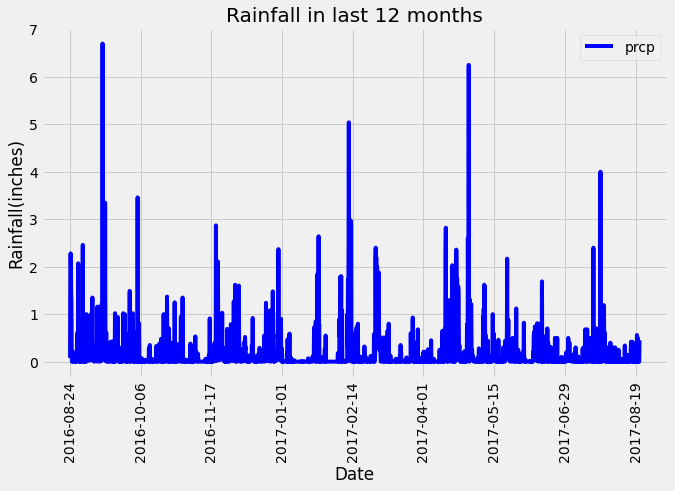

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(color="blue", figsize=(10,6), rot=90)
plt.xlabel("Date")
plt.ylabel("Rainfall(inches)")
plt.title("Rainfall in last 12 months")
plt.savefig("Output_Images/Precipitation.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations=session.query(Station).count()
total_stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station= session.query(Measurement.station, func.count(Measurement.station)).\
         group_by(Measurement.station).\
         order_by(func.count(Measurement.station).desc()).all()
list(active_station)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_query=session.query(Measurement.station, 
                       func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)).\
         filter(Measurement.station == "USC00519281").all()
temp_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
hightemp_station=session.query(Measurement.station, func.count(Measurement.tobs)).\
                 group_by(Measurement.station).\
                 order_by(func.count(Measurement.tobs).desc()).first()
list(hightemp_station)                            


['USC00519281', 2772]

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result1= session.query(Measurement.date, Measurement.tobs).\
         filter(Measurement.station == "USC00519281" ).\
         filter(Measurement.date>='2016-08-23' ).all()

#list(result1)

In [25]:
temp_df=pd.DataFrame(result1, columns=["date","tobs"])
temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


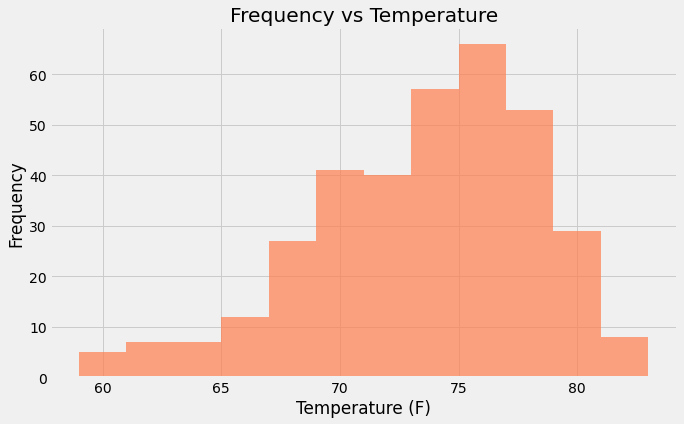

In [26]:
#plotting the results in ahistogram
temp_df.hist(bins=12, label="tobs", alpha=0.7, color="coral", figsize=(10,6))
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Frequency vs Temperature")
plt.savefig("Output_Images/Temperature.png")
plt.show()
             

## Bonus Challenge Assignment

## Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip= calc_temps('2017-08-10', '2017-08-20')
mytrip_df = pd.DataFrame(mytrip, columns=['tmin','tavg','tmax'])
mytrip_df

,tmin,tavg,tmax
0,70.0,78.422222,85.0


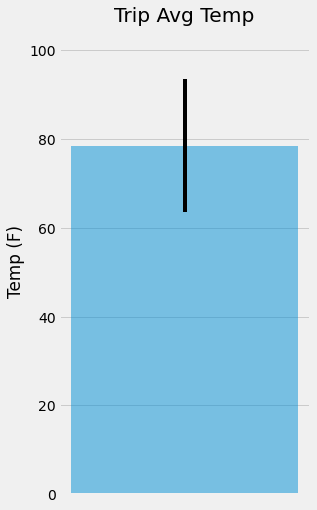

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_value=1
y_value=mytrip_df["tavg"]
yerror =mytrip_df["tmax"]-mytrip_df["tmin"]

plt.figure(figsize=(4,8))
plt.bar(x_value,y_value,yerr=yerror, align="center", alpha=0.5)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.xaxis.grid()


plt.ylim(0,105)
plt.title("Trip Avg Temp")
plt.ylabel('Temp (F)')
plt.savefig("Output_Images/TripAvgTemp.png")
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, Station.longitude, Station.latitude, Station.elevation, Measurement.prcp).\
           filter(Measurement.station == Station.station).\
           filter(Measurement.date >= '2017-08-10').\
           filter(Measurement.date <= '2017-08-20').\
           group_by(Measurement.station).\
           order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4, 0.07), ('USC00519281', 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0, 0.0)]


In [31]:
rainfall_df=pd.DataFrame(rainfall, columns=['Station','Name','Longitude','Latitude','Elevation','Total Prcp'])
rainfall_df.set_index('Station', inplace = True)
rainfall_df

,Name,Longitude,Latitude,Elevation,Total Prcp
Station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",-157.80250,21.33310,152.4,0.07
USC00519281,"WAIHEE 837.5, HI US",-157.84889,21.45167,32.9,0.00
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",-157.71139,21.33556,19.5,0.00
USC00519397,"WAIKIKI 717.2, HI US",-157.81680,21.27160,3.0,0.00
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",-157.83740,21.52130,7.0,0.00


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date ="2017-08-10"
end_date ="2017-08-20"

# Use the start and end date to create a range of dates
my_trip_dates=pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
trip_days=my_trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for date in trip_days:
    normals.append(*daily_normals(date))
list(normals)

[(65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame(normals,columns=['Min_Temp','Avg_Temp','Max_Temp'])
normals_df['Date']=my_trip_dates
normals_df.set_index('Date', inplace=True)
normals_df

,Min_Temp,Avg_Temp,Max_Temp
Date,,,
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0
2017-08-16,69.0,76.080000,83.0
2017-08-17,69.0,76.125000,83.0
2017-08-18,70.0,76.923077,84.0


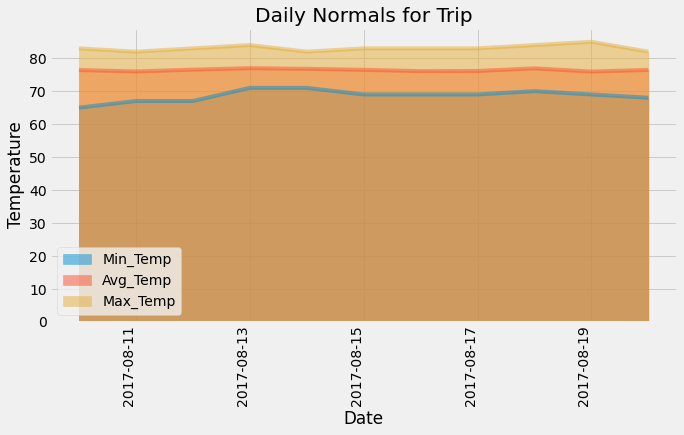

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, figsize=(10,6),rot=90)
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.title("Daily Normals for Trip")
plt.savefig("Output_Images/DailyNormals.png")
plt.show()

## Temperature Analysis I

In [36]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [37]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
from sqlalchemy import extract  
from scipy import stats
from numpy import mean

In [39]:
# Filter for tempretures in June and December
june_query = session.query(Measurement).\
    filter(extract('month', Measurement.date)==6)

dec_query = session.query(Measurement).\
    filter(extract('month', Measurement.date)==12)

In [40]:
print(june_query.statement)

SELECT measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs 
FROM measurement 
WHERE EXTRACT(month FROM measurement.date) = :param_1


In [41]:
june_df = pd.read_sql_query(june_query.statement, session.get_bind())
june_df.head()

,id,station,date,prcp,tobs
0,134,USC00519397,2010-06-01,0.00,78.0
1,135,USC00519397,2010-06-02,0.01,76.0
2,136,USC00519397,2010-06-03,0.00,78.0
3,137,USC00519397,2010-06-04,0.00,76.0
4,138,USC00519397,2010-06-05,0.00,77.0


In [42]:
dec_df = pd.read_sql_query(dec_query.statement, session.get_bind())
dec_df.head()

,id,station,date,prcp,tobs
0,306,USC00519397,2010-12-01,0.04,76.0
1,307,USC00519397,2010-12-03,0.00,74.0
2,308,USC00519397,2010-12-04,0.00,74.0
3,309,USC00519397,2010-12-06,0.00,64.0
4,310,USC00519397,2010-12-07,0.00,64.0


In [43]:
# Filter out null values from lists
june_list = []
for Measurement in june_query:
    if type(Measurement.tobs) == float:
        june_list.append(Measurement.tobs)
        
dec_list = []
for Measurement in dec_query:
    if type(Measurement.tobs) == float:
        dec_list.append(Measurement.tobs)          

In [44]:
# Average temp for June
mean(june_list)

74.94411764705882

In [45]:
# Average temp for December
mean(dec_list)

71.04152933421226

In [46]:
# Unpaired (independent) t-test
stats.ttest_ind(dec_list, june_list)

Ttest_indResult(statistic=-31.60372399000329, pvalue=3.9025129038616655e-191)

# We use unpaired because we are comparing means of two independent/unrelated groups.Since pvalue<0.05 the test is statistically significant